In [206]:
import re
import random
import pandas as pd
import hashlib

In [207]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [208]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,86.726864,8.672686,15.968973,10
Microsoft Purview,167.414441,3.348289,11.726004,50
"Jane Eyre, Bronte",203.066224,29.009461,76.182631,7
DAX,275.676101,30.630678,107.781602,9
Azure AD Authentication,857.330293,71.444191,140.955736,12
TSQL,883.232599,36.801358,130.186776,24
Azure VM + Developer,1070.331260,31.480331,111.616950,34
Logging in Python,1207.831699,86.273693,606.822798,14
Terraform,1329.594374,73.866354,364.080938,18
Azure Private DNS,1347.149618,70.902611,405.202230,19


# Histogram

sum of ages: ~43529.30


<Axes: >

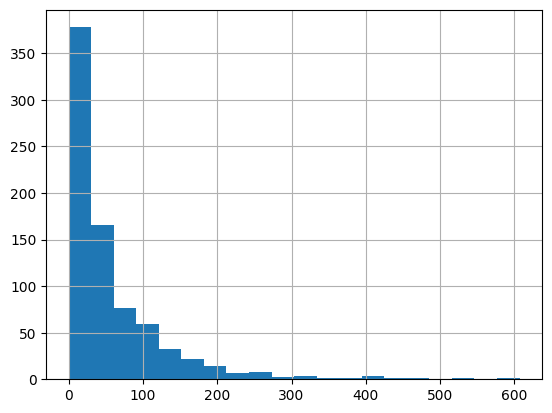

In [209]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~43529.30


<Axes: >

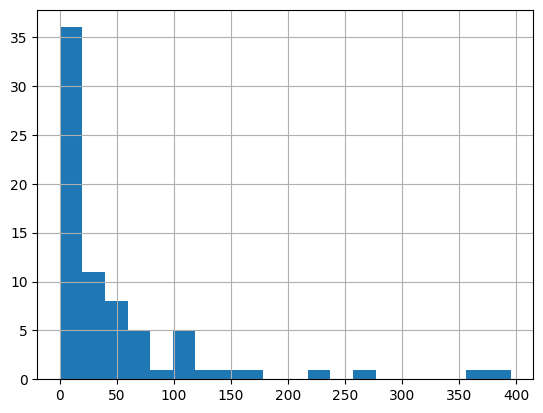

In [210]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [211]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [212]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [213]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [214]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [215]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [216]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [217]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [218]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [219]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [220]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 777
Total card age: 43529.30


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
200,Logging in Python,Q: How can you prevent log messages from bubbl...,ba3ed377fb0e6239644735ac2b86a8c6,606.822798,86.273693,-606.822798,1207.831699,0.731623,0,0,-606.822798
201,Logging in Python,Q: What does the backupCount parameter do in R...,422ecf3cba1bf6d68548feb86c0643a6,74.257211,86.273693,-606.822798,1207.831699,0.731623,3,0,-74.257211
458,Logging in Python,Q: What is the default formatter format string...,fdcd9229a072b73224e0ae14abae04d5,33.496687,86.273693,-606.822798,1207.831699,0.731623,6,0,-33.496687
707,Logging in Python,Q: If a child logger has propagate set to Fals...,36af8e4377e0098d0faff2049ac6ed98,8.962211,86.273693,-606.822798,1207.831699,0.731623,9,0,-8.962211
708,Logging in Python,Q: Why might you choose to use Loguru over Pyt...,eef062671a42262fab39291ccdda1e48,5.452704,86.273693,-606.822798,1207.831699,0.731623,12,0,-5.452704
118,PowerShell Modules,Install-Module\n\nDefinition: A cmdlet used to...,abd837efe7378e3e46b08d09a459cae3,545.322507,87.507403,-545.322507,2800.236896,0.193616,0,0,-545.322507
119,PowerShell Modules,Ensure scripts use the correct module versions...,2402d2f5a53adb6949774297eeeb0621,183.152414,87.507403,-545.322507,2800.236896,0.193616,3,0,-183.152414
120,PowerShell Modules,Exporting Functions and Cmdlets\nDefinition: T...,bd35c9936ab6714ca8f150b76830fc98,146.197213,87.507403,-545.322507,2800.236896,0.193616,6,0,-146.197213
121,PowerShell Modules,Module Auto-Import\n\nDefinition: See Auto-Imp...,c2156a33b828bfb3ad22d6cd13f617e3,108.063191,87.507403,-545.322507,2800.236896,0.193616,9,0,-108.063191
122,PowerShell Modules,ActiveDirectory Module\n\nDefinition: A module...,089fb36f01ae2d8da1791e9a07f2af99,75.016973,87.507403,-545.322507,2800.236896,0.193616,12,0,-75.016973


## Card Count

In [221]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [222]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [223]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
758,Azure Developer Associate,Your company is developing a new web applicati...,466f3aae7fb7958ec8752dd6ace75557,0.026916,49.289089,-395.128442,3598.103464,0.04148,72,0,-0.026916
768,Azure Developer Associate,"As a solution architect/developer, you should ...",3836dea9ca37615db8f65e347809311e,0.031409,49.289089,-395.128442,3598.103464,0.04148,71,2,-0.031409
765,Azure Developer Associate,This question tests the candidate's knowledge ...,6f128343401ab9e2a4268777ff6aef05,0.046967,49.289089,-395.128442,3598.103464,0.04148,70,1,-0.046967
756,Azure Developer Associate,You are developing a cloud native containerize...,ea7cc84a0b4e182d43d10107047b608a,0.159481,49.289089,-395.128442,3598.103464,0.04148,69,0,-0.159481
763,Azure Developer Associate,You plan to generate a shared access signature...,139344ea62e081b982ddb6502beefd2c,0.183913,49.289089,-395.128442,3598.103464,0.04148,68,2,-0.183913
249,Microsoft Purview,Data understanding is about ensure data has qu...,9a95bac80e7ba590c49d6bcab8edaf38,0.346392,3.348289,-11.726004,167.414441,0.73361,49,1,-0.346392
772,Azure Developer Associate,Azure Service Bus is a fully managed enterpris...,14990a4c3513cfbc002f19336ba4948b,0.351634,49.289089,-395.128442,3598.103464,0.04148,67,1,-0.351634
750,Microsoft Purview,The most effective end-user documentation will...,cd14ee472435ecdf15fed24da734eca3,0.379712,3.348289,-11.726004,167.414441,0.73361,48,0,-0.379712
775,Azure Developer Associate,An Azure Service Bus queue allows processing o...,edb2738cdefdfce9534678d9fa183073,0.479840,49.289089,-395.128442,3598.103464,0.04148,66,0,-0.479840
776,Azure Developer Associate,Messages carry a payload and metadata. The met...,83f0ced48832dfeb59e870e8820d9672,0.511773,49.289089,-395.128442,3598.103464,0.04148,65,2,-0.511773


In [224]:
existing_cards.head(10).sum()

head                   Logging in PythonLogging in PythonLogging in P...
body                   Q: How can you prevent log messages from bubbl...
hash                   ba3ed377fb0e6239644735ac2b86a8c6422ecf3cba1bf6...
age                                                          1786.743908
subject_mean_age                                              868.905479
subject_highest_age                                         -5760.726528
subject_age_sum                                             20040.342974
head_random_roll                                                4.626193
count                                                                 60
n_fold                                                                 0
neg_age                                                     -1786.743908
dtype: object

In [225]:
existing_cards['age'].mean()

56.022266751795314